# EEG Alpha Power Decoding with LDA

This script analyzes EEG data to classify two conditions using Linear Discriminant Analysis (LDA) on alpha band power (8-12 Hz). It processes data, trains a classifier, and evaluates decoding accuracy using cross-validation.

---

## **1. Data Preprocessing**
- **Data Loading:**
  - Loads preprocessed EEG data for multiple subjects from `.npz` files.
  - Extracts trial data (`X`), labels (`y`), and sampling frequency (`fs`).

- **Channel Selection:**
  - Focuses on specific channels of interest: `O1`, `O2`, `P3`, `P4`, `P7`, and `P8`.
  - Excludes subject-specific noisy channels based on a rejection list.

- **Signal Processing:**
  - Applies a bandpass filter (8-12 Hz) to isolate the alpha frequency band.
  - Crops edge artifacts to minimize boundary effects.
  - Computes the *log-transformed mean amplitude of the Hilbert transform* to quantify alpha power.

---

## **2. Decoding with LDA**
- **Cross-Validation Setup:**
  - Uses 4-fold cross-validation to split trials into training and test sets.

- **Model Training and Testing:**
  - Initializes an LDA classifier with Ledoit-Wolf covariance regularization for stability.
  - Trains the LDA model on training data and evaluates performance on test data.
  - Computes accuracy for each fold.

- **Performance Metrics:**
  - Calculates the mean decoding accuracy and standard error (SE) across folds for each subject.

---

## **3. Results Storage**
- Compiles results into a structured numpy array, including:
  - **Subject ID**
  - **Mean Accuracy**
  - **Standard Error**
- Saves results to a designated directory for further analysis.

---

## **4. Output**
- **Metrics:** Provides subject-wise decoding accuracy and standard error.
- **File Storage:** Saves results in `.npy` format under `decoding_results_dir` for easy integration with subsequent analyses.

---

## **Purpose**
This pipeline evaluates the ability of alpha band features to decode left vs right attending trials.


In [22]:
import os
import numpy as np
from scipy.signal import hilbert, butter, sosfilt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from os.path import join

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))

analysis_dir = join(data_dir, "analysis")
alpha_dir = join(analysis_dir, "alpha")
decoding_results_dir = join(alpha_dir, "decoding_results") 
plots_dir = join(alpha_dir, "plots")
features_dir = join(alpha_dir, "plots", "features")

In [23]:

def bandpass_filter(data, lowcut, highcut, fs = 120, order=4):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=fs, output='sos')
    return sosfilt(sos, data, axis=-1)
def compute_average_hilbert_amplitude(data):
    analytic = hilbert(data, axis=-1)
    hilbert_amplitude = np.abs(analytic)
    amplitude_mean = hilbert_amplitude.mean(axis=-1)
    log_mean = np.log(amplitude_mean)
    return log_mean

In [ ]:
subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip",
    "VPpdiq", "VPpdir", "VPpdis", "VPpdit", "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix",
    "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
    ]

picks_hubner = [
    "F7", "F3", "Fz", "F4", "F8", "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"
]

subjects_channel_reject = {
    "VPpdib": ["CP2"],
    "VPpdih": ["C3"],
    "VPpdizb": ["Fz"],
    "VPpdizc": ["FC2"]
}

In [24]:
task = "covert"
# Channels to extract features from
selected_channels =  ["P3", "P4", 'P7', 'P8', 'O1', 'O2']

# Initialize results storage
results = []

for subject in subjects:
    file_dir = os.path.join(derivatives_dir, 'preprocessed', "alpha", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha.npz")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    picks_clean = picks_hubner.copy()
    
    #Adapt indexing for rejected channels
    if subject in subjects_channel_reject:
        # Get the channels to reject for this subject
        channels_to_reject = subjects_channel_reject[subject]
        # Remove all channels from picks_clean
        for channel in channels_to_reject:
            if channel in picks_clean:
                picks_clean.remove(channel)

    # Load the data from the NPZ file
    npz_data = np.load(file_path)

    # Extract data
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels indicating cued side: trials
    fs = npz_data['fs']  # Sampling frequency
    fs = fs.flatten()[0]   # turn array to integer
    
    
    n_channels = len(selected_channels)
    selected_indices = [picks_clean.index(ch) for ch in selected_channels if ch in picks_clean]

    X = X[:, selected_indices, :]  # Crop to selected channels
    
    # Apply bandpass filter and crop
    X_filtered = bandpass_filter(X, 8, 12, fs=fs)
    X_cropped = X_filtered[:, :, 120:-120]
    
    # Compute Hilbert transform
    X = compute_average_hilbert_amplitude(X_cropped)
    
    # Cross-validation loop
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)

    for i_fold in range(n_folds):
        # Split data into training and test sets
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]
        
        # Initialize LDA with LedoitWolf covariance estimator
        lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())

        # Train the LDA model
        lda.fit(X_trn, y_trn)

        # Predict the labels for test data
        y_pred = lda.predict(X_tst)

        # Compute accuracy
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute mean accuracy and standard error
    mean_accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(len(fold_accuracies)), 2)

    # Store results as tuples
    results.append((subject, mean_accuracy, se))

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)
if not os.path.exists(decoding_results_dir):
        os.makedirs(decoding_results_dir)
        
np.save(join(decoding_results_dir, f"{task}_lda_alpha_{n_channels}-ch_subset_results.npy"), results_array)
print(f"Results saved to {decoding_results_dir}")
print(f"Overall trial level inference accuracy: {np.mean(results_array['accuracy']):.2f} ± {np.mean(results_array['standard_error']):.2f}")

Results saved to C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root\data\analysis\alpha\decoding_results
Overall trial level inference accuracy: 0.77 ± 0.03


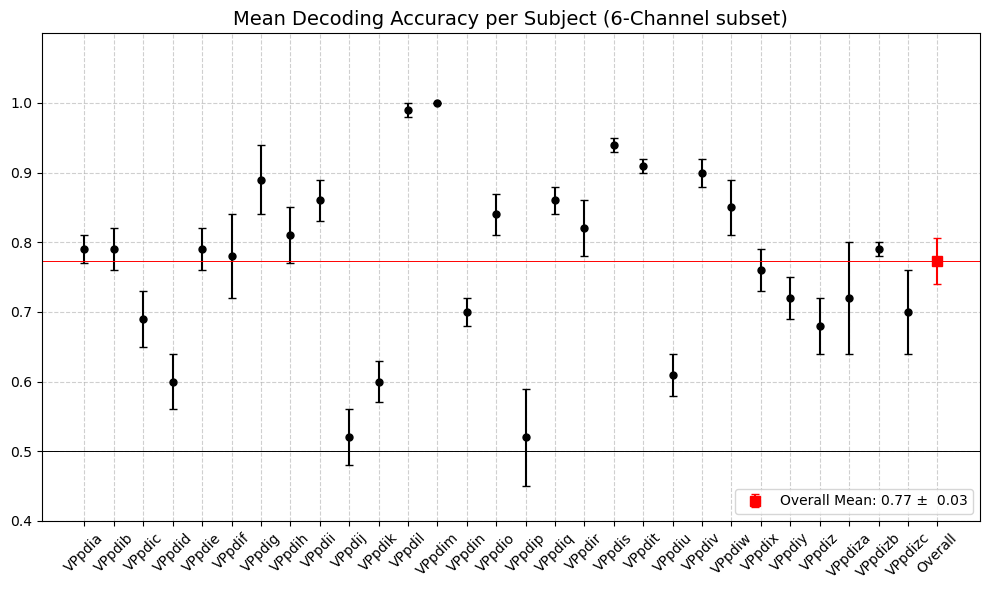

Overall LDA accuracy with subset channels: 0.77 ± 0.03


In [25]:
## Plotting

# Extract relevant fields
subject_accuracies = results_array['accuracy']
subject_ses = results_array['standard_error']
subjects = results_array['subject']

# Compute overall mean accuracy and SE
overall_mean_accuracy = np.mean(subject_accuracies)
overall_se = np.mean(subject_ses)

# Plot individual subject accuracies with SE as error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=range(1, len(subject_accuracies) + 1),  # Subject indices
    y=subject_accuracies,  # Subject accuracies
    yerr=subject_ses,  # Standard errors
    fmt='o',
    color='k',
    ecolor='k',
    capsize=3,
    linestyle='None',
    markersize=5,
    label=''
)

# Add overall mean accuracy and SE as a separate point
plt.errorbar(
    x=[len(subject_accuracies) + 1],  # Place after all subjects
    y=[overall_mean_accuracy],
    yerr=[overall_se],
    fmt='s',
    color='r',
    ecolor='r',
    capsize=3,
    markersize=7,
    label=f'Overall Mean: {overall_mean_accuracy:.2f} ± {overall_se: .2f}'
)

# Customize plot
n_channels = len(selected_channels)
plt.title(f'Mean Decoding Accuracy per Subject ({n_channels}-Channel subset)', fontsize=14)
plt.xticks(
    ticks=range(1, len(subject_accuracies) + 2),  # Subject indices + "Overall"
    labels=list(subjects) + ['Overall'],  # Subject labels + "Overall"
    rotation=45,
    fontsize=10
)
plt.yticks(np.linspace(0, 1, 11))  # Y-axis ticks from 0 to 1 in 0.1 increments
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim([0.4, 1.1])  # Y-axis range
plt.axhline(y=0.5, color='k', linestyle='-', linewidth=0.7, label='')  # Chance level
plt.axhline(y=overall_mean_accuracy, color='r', linestyle='-', linewidth=0.7)  # Overall mean line

# Add legend
plt.legend(loc='lower right', fontsize=10)

# Save or show the plot
plt.tight_layout()
plots_dir = join(alpha_dir, "plots")
os.makedirs(os.path.dirname(plots_dir), exist_ok=True)
plt.savefig(join(plots_dir, f"{task}_alpha_lda_subset_{n_channels}-ch_results.png"), dpi=300)
plt.savefig(join(plots_dir, f"{task}_alpha_lda_subset_{n_channels}-ch_results.svg"), dpi=300)

plt.show()
plt.close()  

# Overall results
print(f"Overall LDA accuracy with subset channels: {overall_mean_accuracy:.2f} ± {overall_se:.2f}")